### Auto-Encoder on MNIST dataset

![model_architecture](tutorial_images/autoencoder/autoencoder_schema.jpg)

In [1]:
#import packages
import matplotlib
matplotlib.use('Agg')
%pylab inline

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from utils import get_mnist
from pyspark import SparkContext
from matplotlib.pyplot import imshow
#create session
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib
Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


In [2]:
#Setting the path for Spark
os.environ['JAVA_HOME']="/usr/lib/jvm/java-8-oracle"
os.environ['SPARK_HOME'] = "/home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['HADOOP_HOME'] = "/usr/local/hadoop/bin"
os.environ['YARN_CONF_DIR'] = "/usr/local/hadoop/etc/hadoop"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/kunal/Downloads/jarfiles/bigdl-SPARK_2.2-0.7.0-jar-with-dependencies.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.3 pyspark-shell'

### Load MNIST dataset

In [3]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "./data/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz


In [4]:
#Map data into BigDL format
train_data = train_data.map(lambda sample:
            Sample.from_ndarray(np.resize(sample.features[0].to_ndarray(), (28*28,)), np.resize(sample.features[0].to_ndarray(), (28*28,))))
test_data = test_data.map(lambda sample:
            Sample.from_ndarray(np.resize(sample.features[0].to_ndarray(), (28*28,)), np.resize(sample.features[0].to_ndarray(), (28*28,))))
print(train_data.count())
print(test_data.count())

60000
10000


In [6]:
# Parameters
training_epochs = 10
batch_size = 128
display_step = 1

# Network Parameters
n_hidden = 32
n_input = 784 # MNIST data input (img shape: 28*28)

In [7]:
# Here the activation layer ReLU and Sigmoid are added into encoder and decoder respectively.
# Define Autoencoder Model
def build_autoencoder(n_input, n_hidden):
    # Initialize a sequential container
    model = Sequential()

    # encoder
    model.add(Linear(n_input, n_hidden))
    model.add(ReLU())
    # decoder
    model.add(Linear(n_hidden, n_input))
    model.add(Sigmoid())
    
    return model

In [8]:
#Model Creation by providing input and hidden layers
model = build_autoencoder(n_input, n_hidden)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid


In [9]:
# Create an Optimizer
optimizer = Optimizer(model=model,training_rdd=train_data,criterion=MSECriterion(),optim_method=Adam(),end_trigger=MaxEpoch(2),batch_size=batch_size)

creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.
  warnings.warn("You are recommended to use `create` method to create an optimizer.")


In [10]:
#App Name
app_name='autoencoder-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
#Check for Summary for training
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',app_name=app_name)
#Optimize the summary for training
optimizer.set_train_summary(train_summary)
#Save model after optimization
print("saving logs to ",app_name)

creating: createTrainSummary
saving logs to  autoencoder-20210104-164007


In [11]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 3 ms, sys: 1.26 ms, total: 4.27 ms
Wall time: 17 s


### Visualization on Tensorboard

In [12]:
%load_ext tensorboard

In [13]:
%tensorboard --logdir=/tmp/bigdl_summaries

Text(0.5,1,'loss')

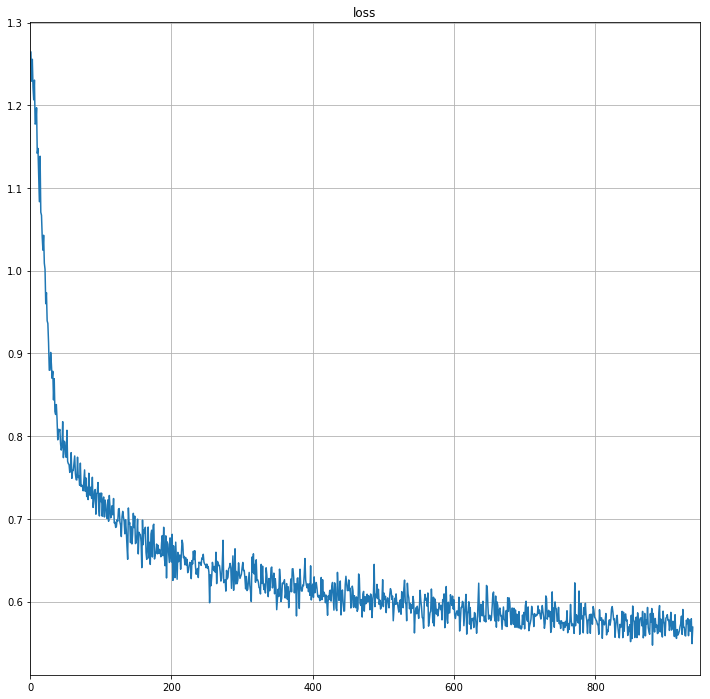

In [14]:
#Data visualization
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

### Prediction on test dataset

Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz


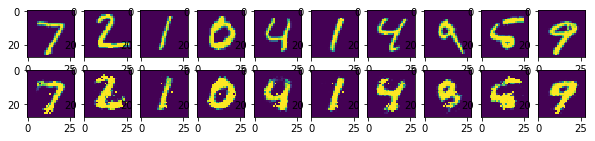

In [15]:
#Take image and their lable for testing
(images, labels) = mnist.read_data_sets(mnist_path, "test")
#Predict test data
examples = trained_model.predict(test_data).take(10)
#Plotting image
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    a[0][i].imshow(np.reshape(images[i], (28, 28)))  #Real image
    a[1][i].imshow(np.reshape(examples[i], (28, 28))) #predict image